# Learning Reachability

In [1]:
# Preamble.
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from labm8 import viz

from experimental.compilers.reachability import reachability_pb2
from experimental.compilers.reachability import control_flow_graph as cfg
from experimental.compilers.reachability import control_flow_graph_generator as cfg_generator
from experimental.compilers.reachability import cfg_datasets as datasets

%matplotlib inline

In [2]:
# Plotting utils.

def GetName(g, n, label_entry_and_exit = True) -> str:
    if label_entry_and_exit:
        if g.nodes[n].get('entry', False):
            return 'Entry'
        if g.nodes[n].get('exit', False):
            return 'Exit'
    return g.nodes[n]['name']
    
def DrawGraph(g: cfg.ControlFlowGraph, ax=None, label_entry_and_exit = True) -> None:
    ax = ax or plt.gca()
    nx.draw_spring(g, labels={n: GetName(g, n, label_entry_and_exit) for n in g.nodes}, node_size=600)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Generating Random CFGs

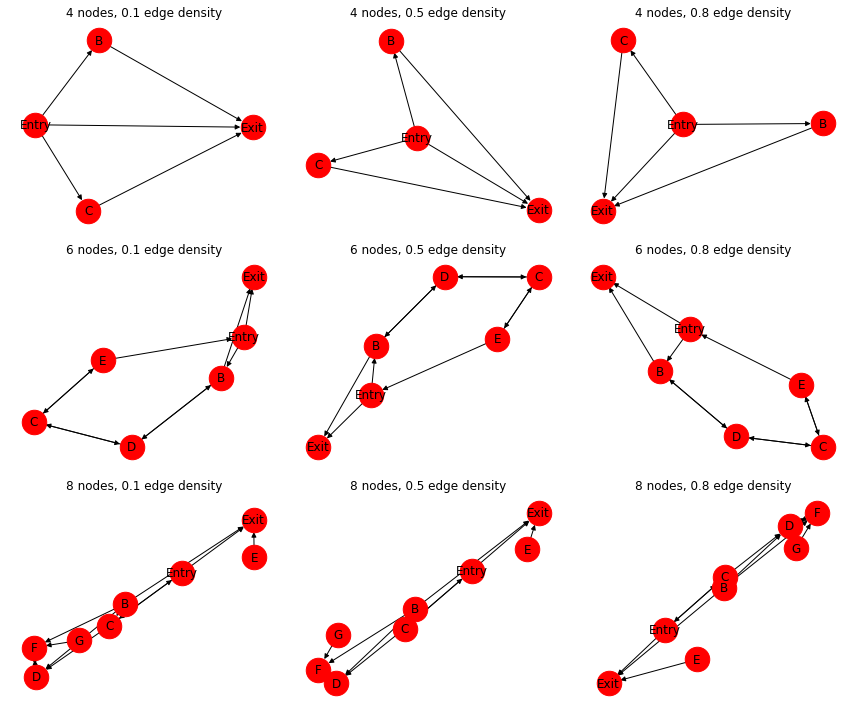

In [3]:
# Parameter sweep to draw a grid of basic blocks.
num_nodes = [4, 6, 8]
edge_densities = [0.1, 0.5, 0.8]

fig = plt.figure(figsize=(int(4 * len(edge_densities)), int(3.5 * len(num_nodes))))
fig.clf()

for j, n in enumerate(num_nodes):
    for i, ed in enumerate(edge_densities):
        ax_index = (j * len(edge_densities)) + i + 1
        ax = fig.add_subplot(len(num_nodes), len(edge_densities), ax_index)
        # Generate a graph with the requested num blocks and edge density. Use the
        # same random seed per row.
        graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(j), (n, n), ed))
        DrawGraph(graph, ax=ax)
        ax.set_title(f'{n} nodes, {ed} edge density')

viz.finalise()

## CFG Reachabilities

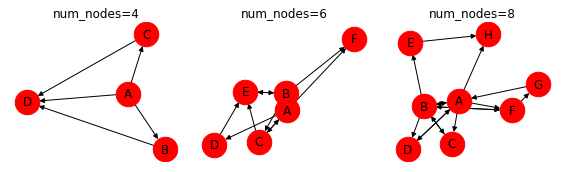

A  B  C  D  E  F  G  H
num_nodes src                        
4         A    ✘  ✓  ✓  ✓            
          B    ✘  ✘  ✘  ✓            
          C    ✘  ✘  ✘  ✓            
          D    ✘  ✘  ✘  ✘            
6         A    ✘  ✓  ✓  ✓  ✓  ✓      
          B    ✓  ✘  ✓  ✓  ✓  ✓      
          C    ✓  ✓  ✘  ✓  ✓  ✓      
          D    ✓  ✓  ✓  ✘  ✓  ✓      
          E    ✓  ✓  ✓  ✓  ✘  ✓      
          F    ✘  ✘  ✘  ✘  ✘  ✘      
8         A    ✘  ✓  ✓  ✓  ✓  ✓  ✓  ✓
          B    ✓  ✘  ✓  ✓  ✓  ✓  ✓  ✓
          C    ✓  ✓  ✘  ✓  ✓  ✓  ✓  ✓
          D    ✓  ✓  ✓  ✘  ✓  ✓  ✓  ✓
          E    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✓
          F    ✓  ✓  ✓  ✓  ✓  ✘  ✓  ✓
          G    ✓  ✓  ✓  ✓  ✓  ✓  ✘  ✓
          H    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✘

In [4]:
def BinArray(array):
    return ['✓' if x else '✘' for x in array]

fig = plt.figure(figsize=(8, 2.5))
fig.clf()

num_nodes = [4, 6, 8]

g = cfg_generator.UniqueNameSequence('A')
node_names = [g for g, _ in zip(g, range(max(num_nodes)))]
edge_density = 0.01
rows = []
for i, n in enumerate(num_nodes):
    graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(0), (n, n), edge_density))
    ax = fig.add_subplot(1, 3, i + 1)
    DrawGraph(graph, ax=ax, label_entry_and_exit=False)
    ax.set_title(f'num_nodes={n}')
    for node in graph.nodes:
        rows.append([graph.number_of_nodes(), node_names[node]] + 
                    BinArray(graph.Reachables(node)) + 
                    [''] * (max(num_nodes) - len(graph.nodes)))

viz.finalise()
df = pd.DataFrame(rows, columns = ['num_nodes', 'src'] + node_names)
df.set_index(['num_nodes', 'src'], inplace=True)
df

## Proportion of Basic Blocks that are Reachable

In [5]:
num_nodes = list(range(4, 31, 2))
edge_density = 0.1
num_graphs = 100

rows = []
for i, n in enumerate(num_nodes):
    generator = cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(0), (n, n), edge_density)
    graphs = generator.GenerateUnique(num_graphs)
    for graph in graphs:
        num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
        rows.append((n, num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

sns.boxplot(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of blocks in CFG')
plt.ylabel('Proportion of reachable blocks')
plt.title(f'Proportion of basic blocks that are reachable ({num_graphs} graphs each)')
plt.ylim((0, 1))
viz.finalise(figsize=(8, 4))

NotImplementedError: 

## OpenCL Dataset

In [6]:
ocl_dataset = datasets.OpenClDeviceMappingsDataset()

ocl_dataset.cfgs_df['program:cfg'] = [
    cfg.ControlFlowGraph.FromProto(reachability_pb2.ControlFlowGraph.FromString(x))
    for x in ocl_dataset.cfgs_df['program:cfg_proto'].values]

graphs = ocl_dataset.cfgs_df['program:cfg'].values

ocl_dataset.cfgs_df

program:cfg_proto  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                                                           
amd-app-sdk-3.0              BinomialOption         binomial_options                 b'\n\x10binomial_options\x12\x04\n\x02%5\x12\x...   
                             FloydWarshall          floydWarshallPass                b'\n\x11floydWarshallPass\x12\x04\n\x02%4\x12\...   
                             MatrixMultiplication   mmmKernel                        b'\n\tmmmKernel\x12\x04\n\x02%5\x12\x05\n\x03%...   
                             PrefixSum              group_prefixSum                  b'\n\x0fgroup_prefixSum\x12\x04\n\x02%5\x12\x0...   
                             Reduction              reduce                           b'\n\x06reduce\x12\x04\n\x02%3\x12\x05\n\x03%2...   
                             ScanLargeArrays        ScanLargeArrays                  b'\n\x0fScanLargeArrays\x12\x04\n\x02%5\x12\x0...   
                                                    blockAddition                    b'\n\rblockAddition\x12\x04\n\x02%2\x12\x04\n\...   
                                                    prefixSum                        b'\n\tprefixSum\x12\x04\n\x02%4\x12\x05\n\x03%...   
                             SimpleConvolution      simpleNonSeparableConvolution    b'\n\x1dsimpleNonSeparableConvolution\x12\x04\...   
                                                    simpleSeparableConvolutionPass1  b'\n\x1fsimpleSeparableConvolutionPass1\x12\x0...   
                                                    simpleSeparableConvolutionPass2  b'\n\x1fsimpleSeparableConvolutionPass2\x12\x0...   
                             SobelFilter            sobel_filter                     b'\n\x0csobel_filter\x12\x04\n\x02%2\x12\x05\n...   
npb-3.3                      BT                     add                              b'\n\x03add\x12\x04\n\x02%5\x12\x05\n\x03%23\x...   
                                                    compute_rhs1                     b'\n\x0ccompute_rhs1\x12\x05\n\x03%10\x12\x05\...   
                                                    compute_rhs2                     b'\n\x0ccompute_rhs2\x12\x04\n\x02%5\x12\x05\n...   
                                                    compute_rhs3                     b'\n\x0ccompute_rhs3\x12\x05\n\x03%11\x12\x05\...   
                                                    compute_rhs4                     b'\n\x0ccompute_rhs4\x12\x05\n\x03%11\x12\x05\...   
                                                    compute_rhs5                     b'\n\x0ccompute_rhs5\x12\x05\n\x03%11\x12\x05\...   
                                                    compute_rhs6                     b'\n\x0ccompute_rhs6\x12\x04\n\x02%4\x12\x05\n...   
                                                    exact_rhs1                       b'\n\nexact_rhs1\x12\x04\n\x02%4\x12\x05\n\x03...   
                                                    exact_rhs5                       b'\n\nexact_rhs5\x12\x04\n\x02%4\x12\x05\n\x03...   
                                                    initialize1                      b'\n\x0binitialize1\x12\x04\n\x02%4\x12\x05\n\...   
                                                    rhs_norm                         b'\n\x08rhs_norm\x12\x04\n\x02%6\x12\x05\n\x03...   
                                                    x_solve                          b'\n\x07x_solve\x12\x04\n\x02%5\x12\x05\n\x03%...   
                                                    x_solve1                         b'\n\x08x_solve1\x12\x04\n\x02%9\x12\x05\n\x03...   
                                                    x_solve2                         b'\n\x08x_solve2\x12\x04\n\x02%4\x12\x05\n\x03...   
                                                    x_solve3                         b'\n\x08x_solve3\x12\x04\n\x02%6\x12\x05\n\x03...   
                                                    y_solve                          b'\n\x07y_solve\x12\x04\n\x02%

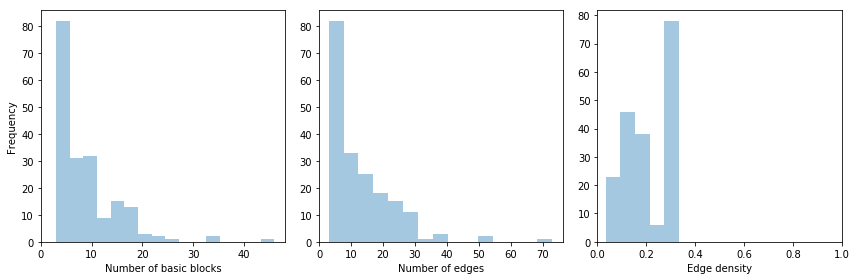

In [24]:
fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
sns.distplot([g.number_of_nodes() for g in graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of basic blocks')
ax.set_ylabel('Frequency')

ax = fig.add_subplot(1, 3, 2)
sns.distplot([g.number_of_edges() for g in graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of edges')

edge_densities = [g.number_of_edges() / (g.number_of_nodes() * g.number_of_nodes()) for g in graphs]
ax = fig.add_subplot(1, 3, 3)
sns.distplot(edge_densities, kde=False, ax=ax)
ax.set_xlim((0, 1))
ax.set_xlabel('Edge density')

viz.finalise()

In [28]:
valid = [g.IsValidControlFlowGraph() for g in graphs]
print(f'{sum(valid)} of {len(valid)} ({sum(valid) / len(valid):.1%}) graphs are valid')

98 of 191 (51.3%) graphs are valid


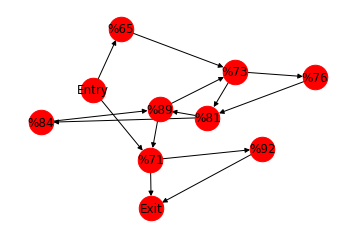

In [8]:
DrawGraph(graphs[0])

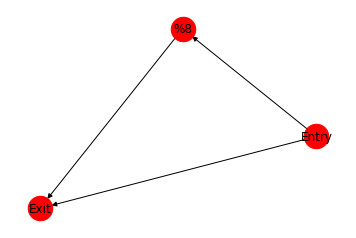

In [11]:
DrawGraph(graphs[6])

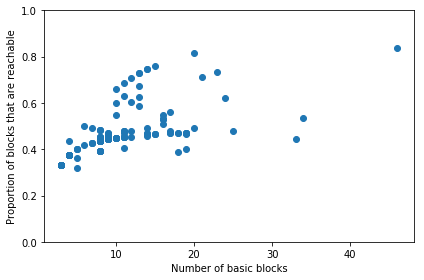

In [18]:
rows = []
for i, graph in enumerate(graphs):
    num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
    rows.append((graph.number_of_nodes(), num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

plt.scatter(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of basic blocks')
plt.ylabel('Proportion of blocks that are reachable')
plt.ylim((0, 1))
viz.finalise()